## Loading Libraries and Dataset

In [ ]:
#Setting google drive as a directory for dataset
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
!pip install Bio

In [ ]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Image

from Bio.Seq import Seq
from Bio.SeqUtils import gc_fraction

from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, KFold
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
from sklearn.metrics import confusion_matrix, accuracy_score
sns.set_theme(style='dark', palette='crest')
%matplotlib inline

In [ ]:
human_df = pd.read_table('/content/gdrive/MyDrive/Datasets/DNASequenceClassifier_Datasets/human_data.txt')

## Data Exploration

In [ ]:
human_df.head()

,sequence,class
0,ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...,4
1,ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...,4
2,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
3,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3
4,ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...,3


In [ ]:
human_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4380 entries, 0 to 4379
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sequence  4380 non-null   object
 1   class     4380 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 68.6+ KB


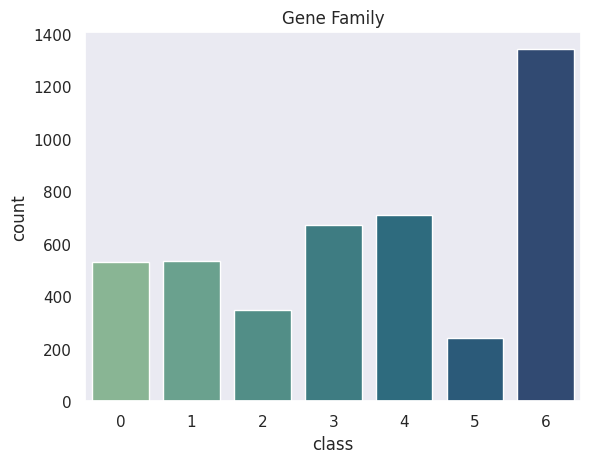

In [ ]:
sns.countplot(x ='class', data = human_df, palette='crest')
plt.title("Gene Family")
plt.show()

In [ ]:
# Image("Capture1.PNG")

In [ ]:
sample_seq = Seq(human_df["sequence"][0])
print('Sample sequence : {}'.format(sample_seq))
print('Complement : {}'.format(sample_seq.complement()))
print('Reverse complement : {}'.format(sample_seq.reverse_complement()) )

Sample sequence : ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCATACTCCTTACACTATTCCTCATCACCCAACTAAAAATATTAAACACAAACTACCACCTACCTCCCTCACCAAAGCCCATAAAAATAAAAAATTATAACAAACCCTGAGAACCAAAATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG
Complement : TACGGGGTTGATTTATGATGGCATACCGGGTGGTATTAATGGGGGTATGAGGAATGTGATAAGGAGTAGTGGGTTGATTTTTATAATTTGTGTTTGATGGTGGATGGAGGGAGTGGTTTCGGGTATTTTTATTTTTTAATATTGTTTGGGACTCTTGGTTTTACTTGCTTTTAGACAAGCGAAGTAAGTAACGGGGGTGTTAGGATC
Reverse complement : CTAGGATTGTGGGGGCAATGAATGAAGCGAACAGATTTTCGTTCATTTTGGTTCTCAGGGTTTGTTATAATTTTTTATTTTTATGGGCTTTGGTGAGGGAGGTAGGTGGTAGTTTGTGTTTAATATTTTTAGTTGGGTGATGAGGAATAGTGTAAGGAGTATGGGGGTAATTATGGTGGGCCATACGGTAGTATTTAGTTGGGGCAT


In [ ]:
print('GC% : ' + str(gc_fraction(sample_seq)*100))

GC% : 39.61352657004831


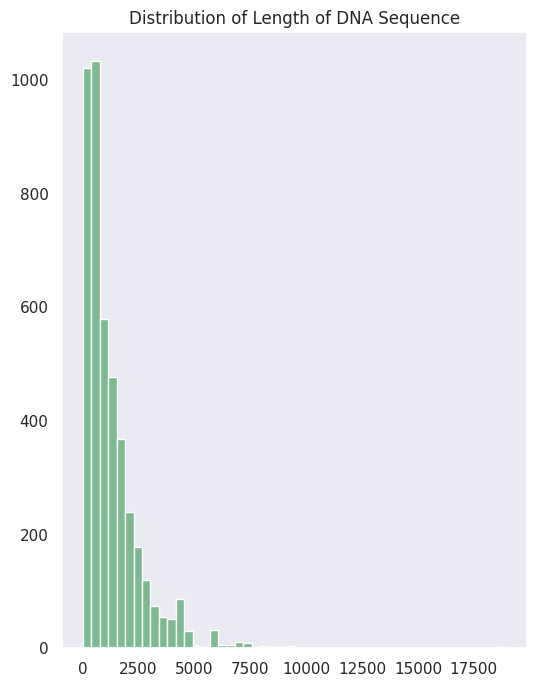

In [ ]:
human_df["length"] = human_df.sequence.apply(lambda x : len(x))
plt.figure(figsize=(6,8))
plt.hist(human_df["length"], bins=50)
plt.title("Distribution of Length of DNA Sequence")
plt.show()

## Data Preprocessing

In [ ]:
def get_kmers(sequence, size=6):
    return [sequence[x:x+size].lower() for x in range(len(sequence) - size + 1)]

In [ ]:
for k in range(3,8):
  human_df['kmers_{}'.format(k)] = human_df.apply(lambda x: get_kmers(x['sequence'], k), axis=1)

In [ ]:
human_df.head()

,sequence,class,length,kmers_3,kmers_4,kmers_5,kmers_6,kmers_7
0,ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...,4,207,"[atg, tgc, gcc, ccc, ccc, cca, caa, aac, act, ...","[atgc, tgcc, gccc, cccc, ccca, ccaa, caac, aac...","[atgcc, tgccc, gcccc, cccca, cccaa, ccaac, caa...","[atgccc, tgcccc, gcccca, ccccaa, cccaac, ccaac...","[atgcccc, tgcccca, gccccaa, ccccaac, cccaact, ..."
1,ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...,4,681,"[atg, tga, gaa, aac, acg, cga, gaa, aaa, aaa, ...","[atga, tgaa, gaac, aacg, acga, cgaa, gaaa, aaa...","[atgaa, tgaac, gaacg, aacga, acgaa, cgaaa, gaa...","[atgaac, tgaacg, gaacga, aacgaa, acgaaa, cgaaa...","[atgaacg, tgaacga, gaacgaa, aacgaaa, acgaaaa, ..."
2,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3,1686,"[atg, tgt, gtg, tgt, gtg, tgg, ggc, gca, cat, ...","[atgt, tgtg, gtgt, tgtg, gtgg, tggc, ggca, gca...","[atgtg, tgtgt, gtgtg, tgtgg, gtggc, tggca, ggc...","[atgtgt, tgtgtg, gtgtgg, tgtggc, gtggca, tggca...","[atgtgtg, tgtgtgg, gtgtggc, tgtggca, gtggcat, ..."
3,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3,1206,"[atg, tgt, gtg, tgt, gtg, tgg, ggc, gca, cat, ...","[atgt, tgtg, gtgt, tgtg, gtgg, tggc, ggca, gca...","[atgtg, tgtgt, gtgtg, tgtgg, gtggc, tggca, ggc...","[atgtgt, tgtgtg, gtgtgg, tgtggc, gtggca, tggca...","[atgtgtg, tgtgtgg, gtgtggc, tgtggca, gtggcat, ..."
4,ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...,3,1437,"[atg, tgc, gca, caa, aac, aca, cag, agc, gca, ...","[atgc, tgca, gcaa, caac, aaca, acag, cagc, agc...","[atgca, tgcaa, gcaac, caaca, aacag, acagc, cag...","[atgcaa, tgcaac, gcaaca, caacag, aacagc, acagc...","[atgcaac, tgcaaca, gcaacag, caacagc, aacagca, ..."


In [ ]:
for k in range(3,8):
  human_df['kmers_{}'.format(k)] = human_df['kmers_{}'.format(k)].apply(lambda x:  ' '.join(x))

In [ ]:
human_df.head()

,sequence,class,length,kmers_3,kmers_4,kmers_5,kmers_6,kmers_7
0,ATGCCCCAACTAAATACTACCGTATGGCCCACCATAATTACCCCCA...,4,207,atg tgc gcc ccc ccc cca caa aac act cta taa aa...,atgc tgcc gccc cccc ccca ccaa caac aact acta c...,atgcc tgccc gcccc cccca cccaa ccaac caact aact...,atgccc tgcccc gcccca ccccaa cccaac ccaact caac...,atgcccc tgcccca gccccaa ccccaac cccaact ccaact...
1,ATGAACGAAAATCTGTTCGCTTCATTCATTGCCCCCACAATCCTAG...,4,681,atg tga gaa aac acg cga gaa aaa aaa aat atc tc...,atga tgaa gaac aacg acga cgaa gaaa aaaa aaat a...,atgaa tgaac gaacg aacga acgaa cgaaa gaaaa aaaa...,atgaac tgaacg gaacga aacgaa acgaaa cgaaaa gaaa...,atgaacg tgaacga gaacgaa aacgaaa acgaaaa cgaaaa...
2,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3,1686,atg tgt gtg tgt gtg tgg ggc gca cat att ttt tt...,atgt tgtg gtgt tgtg gtgg tggc ggca gcat catt a...,atgtg tgtgt gtgtg tgtgg gtggc tggca ggcat gcat...,atgtgt tgtgtg gtgtgg tgtggc gtggca tggcat ggca...,atgtgtg tgtgtgg gtgtggc tgtggca gtggcat tggcat...
3,ATGTGTGGCATTTGGGCGCTGTTTGGCAGTGATGATTGCCTTTCTG...,3,1206,atg tgt gtg tgt gtg tgg ggc gca cat att ttt tt...,atgt tgtg gtgt tgtg gtgg tggc ggca gcat catt a...,atgtg tgtgt gtgtg tgtgg gtggc tggca ggcat gcat...,atgtgt tgtgtg gtgtgg tgtggc gtggca tggcat ggca...,atgtgtg tgtgtgg gtgtggc tgtggca gtggcat tggcat...
4,ATGCAACAGCATTTTGAATTTGAATACCAGACCAAAGTGGATGGTG...,3,1437,atg tgc gca caa aac aca cag agc gca cat att tt...,atgc tgca gcaa caac aaca acag cagc agca gcat c...,atgca tgcaa gcaac caaca aacag acagc cagca agca...,atgcaa tgcaac gcaaca caacag aacagc acagca cagc...,atgcaac tgcaaca gcaacag caacagc aacagca acagca...


In [ ]:
X_dict = {}
cv = CountVectorizer(ngram_range=(5,5))
for k in range(3,8):
  X_dict['X_{}'.format(k)] = cv.fit_transform(human_df['kmers_{}'.format(k)])

In [ ]:
for k in range(3,7):
  print('X_{}'.format(k), 'shape -', X_dict['X_{}'.format(k)].shape)

X_3 shape - (4380, 16834)
X_4 shape - (4380, 65447)
X_5 shape - (4380, 232414)
X_6 shape - (4380, 602855)


In [ ]:
i=0
for key,value in cv.vocabulary_.items():
    print(f"{key} : {value}")
    i+=1
    if i>10:break

atgcccc tgcccca gccccaa ccccaac cccaact : 236755
tgcccca gccccaa ccccaac cccaact ccaacta : 917217
gccccaa ccccaac cccaact ccaacta caactaa : 623751
ccccaac cccaact ccaacta caactaa aactaaa : 369469
cccaact ccaacta caactaa aactaaa actaaat : 363985
ccaacta caactaa aactaaa actaaat ctaaata : 343135
caactaa aactaaa actaaat ctaaata taaatac : 271298
aactaaa actaaat ctaaata taaatac aaatact : 30851
actaaat ctaaata taaatac aaatact aatacta : 114896
ctaaata taaatac aaatact aatacta atactac : 454629
taaatac aaatact aatacta atactac tactacc : 792495


## Validation

In [ ]:
y = human_df.loc[:, 'class'].values
print(y)

[4 4 3 ... 6 6 6]


In [ ]:
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(X_dict['X_3'], y, test_size = 0.20, random_state=20)
X_train_4, X_test_4, y_train_4, y_test_4 = train_test_split(X_dict['X_4'], y, test_size = 0.20, random_state=20)
X_train_5, X_test_5, y_train_5, y_test_5 = train_test_split(X_dict['X_5'], y, test_size = 0.20, random_state=20)
X_train_6, X_test_6, y_train_6, y_test_6 = train_test_split(X_dict['X_6'], y, test_size = 0.20, random_state=20)
X_train_7, X_test_7, y_train_7, y_test_7 = train_test_split(X_dict['X_7'], y, test_size = 0.20, random_state=20)

In [ ]:
nb_clf = MultinomialNB(alpha=0.1)

In [ ]:
kf = KFold(n_splits=10)
score_cv_3 = cross_val_score(nb_clf, X_train_3, y_train_3, cv=kf)
print('___Multinomial Naive Bayes___')
print('CV scores(cv) - ', score_cv_3)
print('Mean score(cv) - ', score_cv_3.mean())

___Multinomial Naive Bayes___
CV scores(cv) -  [0.86324786 0.84330484 0.87179487 0.86894587 0.86       0.85714286
 0.84571429 0.82285714 0.85142857 0.85142857]
Mean score(cv) -  0.8535864875864876


In [ ]:
kf = KFold(n_splits=10)
score_cv_4 = cross_val_score(nb_clf, X_train_4, y_train_4, cv=kf)
print('___Multinomial Naive Bayes___')
print('CV scores(cv) - ', score_cv_4)
print('Mean score(cv) - ', score_cv_4.mean())

___Multinomial Naive Bayes___
CV scores(cv) -  [0.94586895 0.94301994 0.95441595 0.97435897 0.93142857 0.93142857
 0.94857143 0.92571429 0.94285714 0.91142857]
Mean score(cv) -  0.9409092389092388


In [ ]:
kf = KFold(n_splits=10)
score_cv_5 = cross_val_score(nb_clf, X_train_5, y_train_5, cv=kf)
print('___Multinomial Naive Bayes___')
print('CV scores(cv) - ', score_cv_5)
print('Mean score(cv) - ', score_cv_5.mean())

___Multinomial Naive Bayes___
CV scores(cv) -  [0.96866097 0.95726496 0.96581197 0.98575499 0.96571429 0.94285714
 0.97714286 0.95714286 0.97714286 0.95714286]
Mean score(cv) -  0.9654635734635735


In [ ]:
kf = KFold(n_splits=10)
score_cv_6 = cross_val_score(nb_clf, X_train_6, y_train_6, cv=kf)
print('___Multinomial Naive Bayes___')
print('CV scores(cv) - ', score_cv_6)
print('Mean score(cv) - ', score_cv_6.mean())

___Multinomial Naive Bayes___
CV scores(cv) -  [0.96581197 0.96581197 0.96866097 0.96581197 0.96285714 0.96857143
 0.97714286 0.95428571 0.97428571 0.96571429]
Mean score(cv) -  0.966895400895401


In [ ]:
kf = KFold(n_splits=10)
score_cv_7 = cross_val_score(nb_clf, X_train_7, y_train_7, cv=kf)
print('___Multinomial Naive Bayes___')
print('CV scores(cv) - ', score_cv_7)
print('Mean score(cv) - ', score_cv_7.mean())

___Multinomial Naive Bayes___
CV scores(cv) -  [0.94301994 0.94871795 0.96011396 0.94017094 0.94571429 0.94857143
 0.97714286 0.92571429 0.95142857 0.95714286]
Mean score(cv) -  0.9497737077737078


kmers_3 - 85.35864875864876
kmers_4 - 94.09092389092389
kmers_5 - 96.54635734635735
kmers_6 - 96.6895400895401
kmers_7 - 94.97737077737078


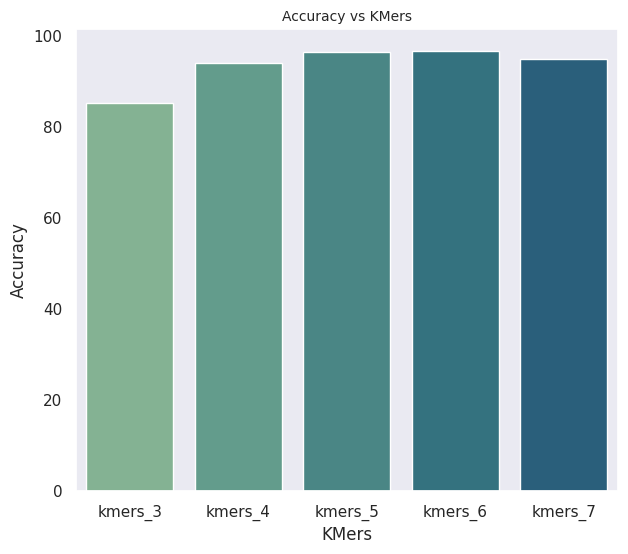

In [ ]:
acc_list=[]
acc_list.append(100*score_cv_3.mean())
acc_list.append(100*score_cv_4.mean())
acc_list.append(100*score_cv_5.mean())
acc_list.append(100*score_cv_6.mean())
acc_list.append(100*score_cv_7.mean())

kmers_list=['kmers_3', 'kmers_4', 'kmers_5', 'kmers_6', 'kmers_7']
for i in range(5):
  print(kmers_list[i],'-',acc_list[i])

plt.figure(figsize=(7,6))
ax = sns.barplot(x=kmers_list, y=acc_list)
plt.xlabel("KMers")
plt.ylabel("Accuracy")
plt.title("Accuracy vs KMers", fontsize=10)
plt.show()

## Prediction and Evaluation

In [ ]:
nb_clf.fit(X_train_3, y_train_3)
y_pred_3 = nb_clf.predict(X_test_3)
accuracy_3 = accuracy_score(y_test_3, y_pred_3)
print(accuracy_3)

0.8595890410958904


In [ ]:
nb_clf.fit(X_train_4, y_train_4)
y_pred_4 = nb_clf.predict(X_test_4)
accuracy_4 = accuracy_score(y_test_4, y_pred_4)
print(accuracy_4)

0.9726027397260274


In [ ]:
nb_clf.fit(X_train_5, y_train_5)
y_pred_5 = nb_clf.predict(X_test_5)
accuracy_5 = accuracy_score(y_test_5, y_pred_5)
print(accuracy_5)

0.9874429223744292


In [ ]:
nb_clf.fit(X_train_6, y_train_6)
y_pred_6 = nb_clf.predict(X_test_6)
accuracy_6 = accuracy_score(y_test_6, y_pred_6)
print(accuracy_6)

0.9874429223744292


In [ ]:
nb_clf.fit(X_train_7, y_train_7)
y_pred_7 = nb_clf.predict(X_test_7)
accuracy_7 = accuracy_score(y_test_7, y_pred_7)
print(accuracy_7)

0.9657534246575342


kmers_3 - 85.95890410958904
kmers_4 - 97.26027397260275
kmers_5 - 98.74429223744292
kmers_6 - 98.74429223744292
kmers_7 - 96.57534246575342


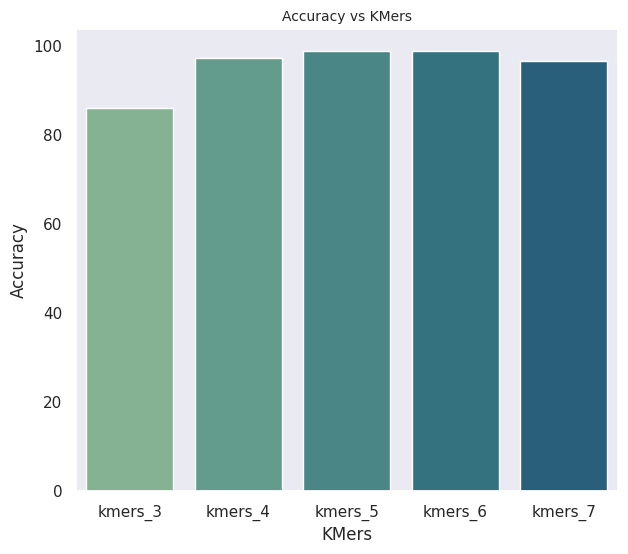

In [ ]:
acc_list=[]
acc_list.append(100*accuracy_3))
acc_list.append(100*accuracy_4)
acc_list.append(100*accuracy_5)
acc_list.append(100*accuracy_6)
acc_list.append(100*accuracy_7)

kmers_list=['kmers_3', 'kmers_4', 'kmers_5', 'kmers_6', 'kmers_7']
for i in range(5):
  print(kmers_list[i],'-',acc_list[i])

plt.figure(figsize=(7,6))
ax = sns.barplot(x=kmers_list, y=acc_list)
plt.xlabel("KMers")
plt.ylabel("Accuracy")
plt.title("Accuracy vs KMers", fontsize=10)
plt.show()

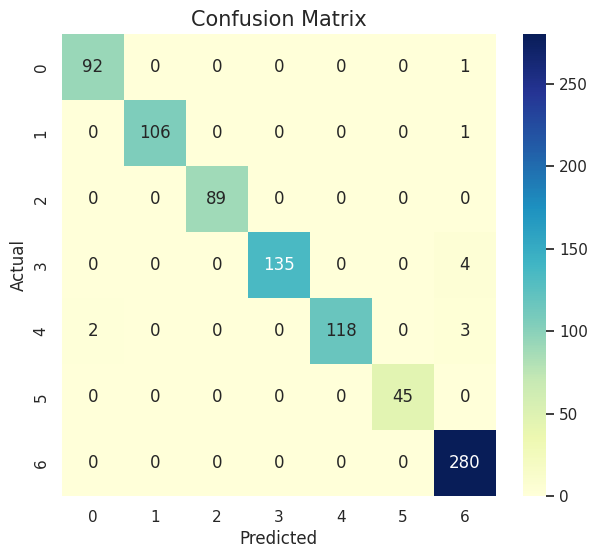

In [ ]:
plt.figure(figsize=(7,6))
sns.heatmap(pd.crosstab(pd.Series(y_test_5, name='Actual'), pd.Series(y_pred_5, name='Predicted')),cmap="YlGnBu",annot=True,fmt='d')
plt.title("Confusion Matrix", fontsize=15)
plt.show()